In [38]:
import torch 
from torch import nn
import torchvision 
from torchvision import datasets,transforms 
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader

In [39]:
train_data = datasets.MNIST(download=True,root='content',train=True,transform=transforms.ToTensor(),target_transform=None)
test_data = datasets.MNIST(download=True,root='content',train=False,transform=transforms.ToTensor())
image,label = train_data[0]
class_names = train_data.classes
print(f"image shape:{image.shape}")
print(f"label:{label}")
print(f"class_names: {class_names}")

image shape:torch.Size([1, 28, 28])
label:5
class_names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [40]:
train_loader = DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(dataset=test_data,batch_size=32)
train_features_batch,train_labels_batch = next(iter(train_loader))
print(f"train_features_batch.shape: {train_features_batch.shape}")
print(f"train_labels_batch.shape: {train_labels_batch.shape}")

train_features_batch.shape: torch.Size([32, 1, 28, 28])
train_labels_batch.shape: torch.Size([32])


In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cuda'

In [42]:
class CNNClf(nn.Module):
    def __init__(self, input_size,hidden_units,output_size):
        super().__init__()
        self.blk1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        
        self.blk2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,out_features=output_size)
        )
    
    def forward(self,x):
        x = self.blk1(x)
        #print(f"Output shape of blk1: {x.shape}")
        x = self.blk2(x)
        #print(f"Output shape of blk2: {x.shape}")
        x = self.clf(x)
        #print(f"Output shape of clf: {x.shape}")
        return x

In [43]:
torch.manual_seed(42)
model = CNNClf(input_size=1,hidden_units=10,output_size=len(class_names)).to(device)
model

CNNClf(
  (blk1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (blk2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [44]:
print(image.shape) 

torch.Size([1, 28, 28])


In [45]:
random_image_tensor = torch.rand(size=(1,28,28))
print(random_image_tensor.shape)
random_image_tensor= random_image_tensor.unsqueeze(dim=0)
print(random_image_tensor.shape)

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


In [46]:
model(random_image_tensor.to(device))

tensor([[ 0.0372, -0.0748,  0.0573, -0.0396, -0.0098,  0.0194, -0.0003, -0.0114,
          0.0206,  0.0003]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [47]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [48]:
def accuracy_fn(y,y_pred):
    correct = torch.eq(y_pred,y).sum().item()
    acc = (correct/len(y_pred))*100
    return acc 

In [49]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss,train_acc = 0,0
    model.to(device)
    for batch,(X,y) in enumerate(data_loader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss
        train_acc += accuracy_fn(y,y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss : {train_loss:4f} | Train accuracy : {train_acc:4f}")

def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    model.to(device)
    model.eval()
    test_loss,test_acc = 0,0
    with torch.inference_mode():
        for X,y in data_loader:
             X,y = X.to(device),y.to(device)
             test_pred = model(X)
             test_loss += loss_fn(test_pred,y)
             test_acc += accuracy_fn(y,test_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

In [50]:
torch.manual_seed(42)
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch+1} ------")
    train_step(model,train_loader,loss_fn,optimizer,accuracy_fn,device)
    test_step(model,test_loader,loss_fn,accuracy_fn,device)


Epoch 1 ------


Train loss : 0.212488 | Train accuracy : 93.336667
Test loss: 0.0777 | Test accuracy: 97.6138
Epoch 2 ------
Train loss : 0.072154 | Train accuracy : 97.776667
Test loss: 0.0463 | Test accuracy: 98.5124
Epoch 3 ------
Train loss : 0.055821 | Train accuracy : 98.216667
Test loss: 0.0492 | Test accuracy: 98.4325


In [51]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    model.eval()
    pred_probs = []
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample,dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [52]:
import random 
random.seed(42)
test_samples,test_labels = [],[]
for sample,label in random.sample(list(test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 2 (2 - two)


In [53]:
pred_probs = make_predictions(model,test_samples,device)
pred_probs[:2]

tensor([[5.4066e-09, 3.3396e-06, 9.9998e-01, 3.6742e-08, 5.2377e-17, 2.7952e-13,
         3.5234e-13, 1.8913e-09, 1.2121e-05, 2.7676e-10],
        [3.0626e-06, 9.8696e-01, 6.2832e-04, 8.9365e-05, 3.7262e-04, 4.9944e-04,
         6.8978e-04, 5.7577e-04, 9.5054e-03, 6.7625e-04]])

In [54]:
pred_classes = pred_probs.argmax(dim=1)
print(pred_classes)
pred_classes,test_labels

tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])


(tensor([2, 1, 2, 4, 6, 6, 4, 9, 1]), [2, 1, 2, 4, 6, 6, 4, 9, 1])

In [55]:
y_preds = []
with torch.inference_mode():
    for X,y in test_loader:
        X,y = X.to(device),y.to(device)
        y_logit = model(X)
        y_pred = torch.softmax(y_logit,dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
y_preds_tensor = torch.cat(y_preds)
y_preds_tensor

tensor([7, 2, 1,  ..., 4, 5, 6])

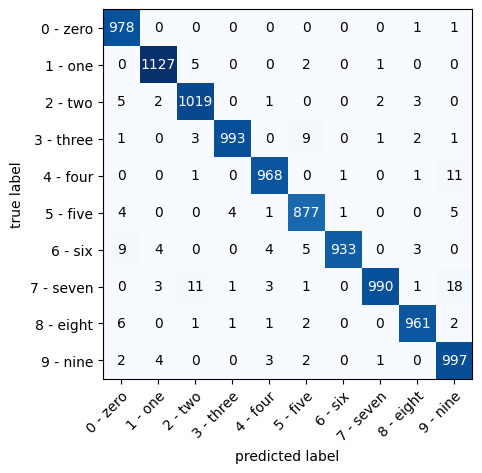

In [56]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
confmat = ConfusionMatrix(num_classes=len(class_names),task='multiclass')
confmat_tensor = confmat(preds = y_preds_tensor,target=test_data.targets)
fig,ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                               class_names=class_names)

Model saving,loading 

In [57]:
from pathlib import Path 
model_path = Path('models')
model_path.mkdir(parents=True,
                 exist_ok=True)
model_name = "mnist.pth"
model_save_path = model_path / model_name
print(f"saving model to {model_save_path}")
torch.save(obj=model.state_dict(),f=model_save_path)

saving model to models\mnist.pth


In [58]:
loaded_model = CNNClf(input_size=1,hidden_units=10,output_size=10)
loaded_model.load_state_dict(torch.load(f=model_save_path))
loaded_model = loaded_model.to(device)
loaded_model

CNNClf(
  (blk1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (blk2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

1. Perform classification on FashionMNIST, fashion apparels dataset, using a pre-trained model which is trained on MNIST handwritten digit classification dataset

In [59]:
train_dataset = datasets.FashionMNIST(root='content',download=True,train=True,transform=transforms.ToTensor(),target_transform=None)
test_dataset = datasets.FashionMNIST(root='content',download=True,train=False,transform=transforms.ToTensor())
image,label = train_data[0]
print(f"image.shape: {image.shape}")
class_names = train_data.classes
print(f"class_names:{class_names}")

image.shape: torch.Size([1, 28, 28])
class_names:['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [60]:
train_dataloader = DataLoader(dataset=train_dataset,batch_size=32,shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=32)
train_features_batch,train_labels_batch = next(iter(train_dataloader))
print(f"train_features_batch.shape:{train_features_batch.shape}")
print(f"train_labels_batch.shape:{train_labels_batch.shape}")

train_features_batch.shape:torch.Size([32, 1, 28, 28])
train_labels_batch.shape:torch.Size([32])


In [61]:
print("Loaded model's state dict:")
for param in loaded_model.state_dict().keys():
    print(f"{param}\t{loaded_model.state_dict()[param].size()}")
print()

Loaded model's state dict:
blk1.0.weight	torch.Size([10, 1, 3, 3])
blk1.0.bias	torch.Size([10])
blk1.2.weight	torch.Size([10, 10, 3, 3])
blk1.2.bias	torch.Size([10])
blk2.0.weight	torch.Size([10, 10, 3, 3])
blk2.0.bias	torch.Size([10])
blk2.2.weight	torch.Size([10, 10, 3, 3])
blk2.2.bias	torch.Size([10])
clf.1.weight	torch.Size([10, 490])
clf.1.bias	torch.Size([10])



In [62]:
loaded_model.eval()
acc = 0
total_samples = 0

for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    y_logit = loaded_model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    print(f"True label: {y}\nPredicted label: {y_pred}")
    
    acc += (y_pred == y).sum().item()
    total_samples += y.size(0)

accuracy = 100.0 * acc / total_samples
print(f"The overall accuracy: {accuracy}")


True label: tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8], device='cuda:0')
Predicted label: tensor([2, 0, 4, 1, 4, 8, 2, 8, 2, 4, 0, 2, 2, 8, 0, 2, 0, 8, 0, 8, 2, 2, 2, 2,
        8, 0, 8, 8, 2, 9, 8, 2], device='cuda:0')


True label: tensor([3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1, 2, 2, 4, 4, 5, 8, 2, 2,
        8, 4, 8, 0, 7, 7, 8, 5], device='cuda:0')
Predicted label: tensor([1, 8, 8, 8, 4, 2, 4, 2, 8, 4, 8, 2, 0, 2, 0, 8, 0, 8, 2, 0, 2, 8, 8, 2,
        0, 0, 0, 8, 2, 2, 2, 2], device='cuda:0')
True label: tensor([1, 1, 2, 3, 9, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2,
        0, 6, 5, 3, 6, 7, 1, 8], device='cuda:0')
Predicted label: tensor([9, 1, 8, 8, 2, 8, 2, 3, 2, 8, 8, 8, 8, 0, 2, 0, 8, 2, 0, 8, 2, 8, 2, 0,
        8, 0, 2, 8, 0, 2, 4, 0], device='cuda:0')
True label: tensor([0, 1, 4, 2, 3, 6, 7, 2, 7, 8, 5, 9, 9, 4, 2, 5, 7, 0, 5, 2, 8, 6, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 4], device='cuda:0')
Predicted label: tensor([8, 8, 0, 0, 3, 0, 2, 0, 2, 2, 2, 2, 1, 0, 0, 4, 2, 8, 5, 0, 0, 8, 4, 2,
        8, 8, 2, 2, 8, 8, 3, 0], device='cuda:0')
True label: tensor([1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 5, 1, 0, 0, 0, 1, 6, 1, 6, 2, 2, 4, 4,
        1, 4, 5, 0, 4, 7, 9, 3], device=

2. Learn the AlexNet architecture and apply transfer learning to perform the classification task. Using the pre-trained AlexNet, classify images from the cats_and_dogs_filtered dataset downloaded from the below link. Finetune the classifier given in AlexNet as a two-class classifier. Perform pre-processing of images as per the requirement.
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip


In [86]:
from torchvision.models import alexnet,AlexNet_Weights
weights =  AlexNet_Weights.DEFAULT
weights

AlexNet_Weights.IMAGENET1K_V1

In [87]:
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [91]:

train_dataset = datasets.ImageFolder(root=r'C:\Users\rsurs\OneDrive\Documents\University_Study Material\3rd year\6th sem\DL_lab\RNN\CNN\cats_and_dogs_filtered\cats_and_dogs_filtered\train',transform=auto_transform)
test_dataset = datasets.ImageFolder(root=r'C:\Users\rsurs\OneDrive\Documents\University_Study Material\3rd year\6th sem\DL_lab\RNN\CNN\cats_and_dogs_filtered\cats_and_dogs_filtered\validation',transform=auto_transform)
train_dataloader = DataLoader(dataset=train_dataset,batch_size=32,shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=32)
class_names = train_dataset.classes
print(f"No of Classes:{len(class_names)}")

No of Classes:2


In [92]:
model = alexnet(weights=weights).to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [93]:
from torchinfo import summary
summary(model=model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 256, 6, 6]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 55, 55]     23,296               True
│    └─ReLU (1)                          [32, 64, 55, 55]     [32, 64, 55, 55]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 55, 55]     [32, 64, 27, 27]     --                   --
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]    307,392              True
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]    --                   --
│    └─Conv2d (6)     

In [94]:
for param in model.features.parameters():
    param.requires_grad = False

In [95]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
output_shape = len(class_names)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features,output_shape,bias=True)
).to(device)

In [96]:
summary(model,
        input_size=(32,3,224,224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 256, 6, 6]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 55, 55]     (23,296)             False
│    └─ReLU (1)                          [32, 64, 55, 55]     [32, 64, 55, 55]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 55, 55]     [32, 64, 27, 27]     --                   --
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]    (307,392)            False
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]    --                   --
│    └─Conv2d (6

In [98]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [99]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train()
    train_loss,train_acc = 0,0
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    model.eval()
    test_loss,test_acc = 0,0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits,y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


In [100]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch}:------")
    train_step(model,train_dataloader,loss_fn,optimizer,device)
    test_step(model,test_dataloader,loss_fn,device)

Epoch 0:------
Train Loss: 0.8036 | Train Accuracy: 0.8953
Test Loss: 0.3961 | Test Accuracy: 0.8789
Epoch 1:------
Train Loss: 0.1918 | Train Accuracy: 0.9464
Test Loss: 0.2409 | Test Accuracy: 0.9453
Epoch 2:------
Train Loss: 0.2220 | Train Accuracy: 0.9529
Test Loss: 0.2787 | Test Accuracy: 0.9463
Epoch 3:------
Train Loss: 0.1884 | Train Accuracy: 0.9663
Test Loss: 0.3630 | Test Accuracy: 0.9492
Epoch 4:------
Train Loss: 0.1926 | Train Accuracy: 0.9658
Test Loss: 0.3949 | Test Accuracy: 0.9336
